In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

np.random.seed(123)

## k-nearest-neighbor algorithm

The k-nn algorithm is a simple **supervised** machine learning algorithm that can be used both for classification and regression. It's an **instance-based** algorithm. So instead of estimating a model, it stores all training examples in memory and makes predictions using a similarity measure. 

Given an input example, the k-nn algorithm retrieves the k most similar instances from memory. Similarity is defined in terms of distance, that is, the training examples with the smallest (euclidean) distance to the input example are considered to be most similar.

The target value of the input example is computed as follows:  
  
Classification:  
a) unweighted: output the most common classification among the k-nearest neighbors  
b) weighted: sum up the weights of the k-nearest neighbors for each classification value, output classification with highest weight  
  
Regression:  
a) unweighted: output the average of the values of the k-nearest neighbors  
b) weighted: for all classification values,  sum up classification value$*$weight and divide the result trough the sum of all weights  

The weighted k-nn version is a refined version of the algorithm in which the contribution of each neighbor is *weighted* according to its distance to the query point. Below, we implement the basic unweighted version of the k-nn algorithm for the digits dataset from sklearn.

X_train shape: (1347, 64)
y_train shape: (1347,)
X_test shape: (450, 64)
y_test shape: (450,)


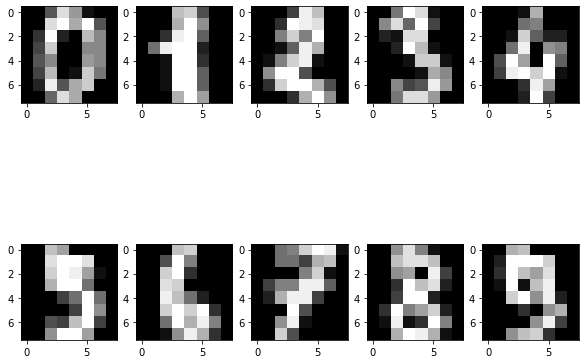

In [2]:
# We will use the digits dataset as an example. It consists of the 1797 images of hand-written digits. Each digit is
# represented by a 64-dimensional vector of pixel values.

digits = load_digits()
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

# Example digits
fig = plt.figure(figsize=(10,8))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    plt.imshow(X[i].reshape((8,8)), cmap='gray')
    
plt.show()

In [3]:
class kNN():
    def __init__(self):
        pass

    def fit(self, X, y):
        self.data = X
        self.targets = y

    def euclidean_distance(self, X):
        """
        Computes the euclidean distance between the training data and
        a new input example or matrix of input examples X
        """
        # input: single data point
        if X.ndim == 1:
            l2 = np.sqrt(np.sum((self.data - X)**2, axis=1))

        # input: matrix of data points
        if X.ndim == 2:
            n_samples, _ = X.shape
            l2 = [np.sqrt(np.sum((self.data - X[i])**2, axis=1)) for i in range(n_samples)]

        return np.array(l2)

    def predict(self, X, k=1):
        """
        Predicts the classification for an input example or matrix of input examples X
        """
        # step 1: compute distance between input and training data
        dists = self.euclidean_distance(X)

        # step 2: find the k nearest neighbors and their classifications
        if X.ndim == 1:
            if k == 1:
                nn = np.argmin(dists)
                return self.targets[nn]
            else:
                knn = np.argsort(dists)[:k]
                y_knn = self.targets[knn]
                max_vote = max(y_knn, key=list(y_knn).count)
                return max_vote

        if X.ndim == 2:
            knn = np.argsort(dists)[:, :k]
            y_knn = self.targets[knn]
            if k == 1:
                return y_knn.T
            else:
                n_samples, _ = X.shape
                max_votes = [max(y_knn[i], key=list(y_knn[i]).count) for i in range(n_samples)]
                return max_votes

In [4]:
knn = kNN()
knn.fit(X_train, y_train)

print("Testing one datapoint, k=1")
print(f"Predicted label: {knn.predict(X_test[0], k=1)}")
print(f"True label: {y_test[0]}")
print()
print("Testing one datapoint, k=5")
print(f"Predicted label: {knn.predict(X_test[20], k=5)}")
print(f"True label: {y_test[20]}")
print()
print("Testing 10 datapoint, k=1")
print(f"Predicted labels: {knn.predict(X_test[5:15], k=1)}")
print(f"True labels: {y_test[5:15]}")
print()
print("Testing 10 datapoint, k=4")
print(f"Predicted labels: {knn.predict(X_test[5:15], k=4)}")
print(f"True labels: {y_test[5:15]}")
print()

Testing one datapoint, k=1
Predicted label: 3
True label: 3

Testing one datapoint, k=5
Predicted label: 9
True label: 9

Testing 10 datapoint, k=1
Predicted labels: [[3 1 0 7 4 0 0 5 1 6]]
True labels: [3 1 0 7 4 0 0 5 1 6]

Testing 10 datapoint, k=4
Predicted labels: [3, 1, 0, 7, 4, 0, 0, 5, 1, 6]
True labels: [3 1 0 7 4 0 0 5 1 6]



In [5]:
# Compute accuracy on test set
y_p_test1 = knn.predict(X_test, k=1)
test_acc1= np.sum(y_p_test1[0] == y_test)/len(y_p_test1[0]) * 100
print(f"Test accuracy with k = 1: {format(test_acc1)}")

y_p_test5 = knn.predict(X_test, k=5)
test_acc5= np.sum(y_p_test5 == y_test)/len(y_p_test5) * 100
print(f"Test accuracy with k = 5: {format(test_acc5)}")

Test accuracy with k = 1: 97.77777777777777
Test accuracy with k = 5: 97.55555555555556


## Decision tree for classification in plain Python


A decision tree is a **supervised** machine learning model that can be used both for **classification** and **regression**. At its core, a decision tree uses a tree structure to predict an output value for a given input example. In the tree, each path from the root node to a leaf node represents a *decision path* that ends in a predicted value. 

A simple example might look as follows:
![caption](figures/decision_tree.png)

Decision trees have many advantages. For example, they are easy to understand and their decisions are easy to interpret. Also, they don't require a lot of data preparation. A more extensive list of their advantages and disadvantages can be found [here](http://scikit-learn.org/stable/modules/tree.html).

### CART training algorithm 
In order to train a decision tree, various algorithms can be used. In this notebook we will focus on the *CART* algorithm (Classification and Regression Trees) for *classification*. The CART algorithm builds a *binary tree* in which every non-leaf node has exactly two children (corresponding to a yes/no answer). 

Given a set of training examples and their labels, the algorithm repeatedly splits the training examples $D$ into two subsets $D_{left}, D_{right}$ using some feature $f$ and feature threshold $t_f$ such that samples with the same label are grouped together. At each node, the algorithm selects the split $\theta = (f, t_f)$ that produces the purest subsets, weighted by their size. Purity/impurity is measured using the *Gini impurity*.

So at each step, the algorithm selects the parameters $\theta$ that minimize the following cost function:

\begin{equation}
J(D, \theta) = \frac{n_{left}}{n_{total}} G_{left} + \frac{n_{right}}{n_{total}} G_{right}
\end{equation}

- $D$: remaining training examples   
- $n_{total}$ : number of remaining training examples
- $\theta = (f, t_f)$: feature and feature threshold
- $n_{left}/n_{right}$: number of samples in the left/right subset
- $G_{left}/G_{right}$: Gini impurity of the left/right subset

This step is repeated recursively until the *maximum allowable depth* is reached or the current number of samples $n_{total}$ drops below some minimum number. The original equations can be found [here](http://scikit-learn.org/stable/modules/tree.html).

After building the tree, new examples can be classified by navigating through the tree, testing at each node the corresponding feature until a leaf node/prediction is reached.


### Gini Impurity

Given $K$ different classification values $k \in \{1, ..., K\}$ the Gini impurity of node $m$ is computed as follows:

\begin{equation}
G_m = 1 - \sum_{k=1}^{K} (p_{m,k})^2
\end{equation}

where $p_{m, k}$ is the fraction of training examples with class $k$ among all training examples in node $m$.

The Gini impurity can be used to evaluate how good a potential split is. A split divides a given set of training examples into two groups. Gini measures how "mixed" the resulting groups are. A perfect separation (i.e. each group contains only samples of the same class) corresponds to a Gini impurity of 0. If the resulting groups contain equally many samples of each class, the Gini impurity will reach its highest value of 0.5

### Caveats

Without regularization, decision trees are likely to overfit the training examples. This can be prevented using techniques like *pruning* or by providing a maximum allowed tree depth and/or a minimum number of samples required to split a node further.

In [6]:
iris = load_iris()

X, y = iris.data, iris.target

In [7]:
# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape X_test: {X_test.shape}')
print(f'Shape y_test: {y_test.shape}')

Shape X_train: (112, 4)
Shape y_train: (112,)
Shape X_test: (38, 4)
Shape y_test: (38,)


In [8]:
class DecisionTree:
    """
    Decision tree for classification
    """

    def __init__(self):
        self.root_dict = None
        self.tree_dict = None

    def split_dataset(self, X, y, feature_idx, threshold):
        """
        Splits dataset X into two subsets, according to a given feature
        and feature threshold.

        Args:
            X: 2D numpy array with data samples
            y: 1D numpy array with labels
            feature_idx: int, index of feature used for splitting the data
            threshold: float, threshold used for splitting the data

        Returns:
            splits: dict containing the left and right subsets
            and their labels
        """

        left_idx = np.where(X[:, feature_idx] < threshold)
        right_idx = np.where(X[:, feature_idx] >= threshold)

        left_subset = X[left_idx]
        y_left = y[left_idx]

        right_subset = X[right_idx]
        y_right = y[right_idx]

        splits = {
        'left': left_subset,
        'y_left': y_left,
        'right': right_subset,
        'y_right': y_right,
        }

        return splits

    def gini_impurity(self, y_left, y_right, n_left, n_right):
        """
        Computes Gini impurity of a split.

        Args:
            y_left, y_right: target values of samples in left/right subset
            n_left, n_right: number of samples in left/right subset

        Returns:
            gini_left: float, Gini impurity of left subset
            gini_right: gloat, Gini impurity of right subset
        """

        n_total = n_left + n_left

        score_left, score_right = 0, 0
        gini_left, gini_right = 0, 0

        if n_left != 0:
            for c in range(self.n_classes):
                # For each class c, compute fraction of samples with class c
                p_left = len(np.where(y_left == c)[0]) / n_left
                score_left += p_left * p_left
            gini_left = 1 - score_left

        if n_right != 0:
            for c in range(self.n_classes):
                p_right = len(np.where(y_right == c)[0]) / n_right
                score_right += p_right * p_right
            gini_right = 1 - score_right

        return gini_left, gini_right

    def get_cost(self, splits):
        """
        Computes cost of a split given the Gini impurity of
        the left and right subset and the sizes of the subsets
        
        Args:
            splits: dict, containing params of current split
        """
        y_left = splits['y_left']
        y_right = splits['y_right']

        n_left = len(y_left)
        n_right = len(y_right)
        n_total = n_left + n_right

        gini_left, gini_right = self.gini_impurity(y_left, y_right, n_left, n_right)
        cost = (n_left / n_total) * gini_left + (n_right / n_total) * gini_right

        return cost

    def find_best_split(self, X, y):
        """
        Finds the best feature and feature index to split dataset X into
        two groups. Checks every value of every attribute as a candidate
        split.

        Args:
            X: 2D numpy array with data samples
            y: 1D numpy array with labels

        Returns:
            best_split_params: dict, containing parameters of the best split
        """

        n_samples, n_features = X.shape

        best_feature_idx, best_threshold, best_cost, best_splits = np.inf, np.inf, np.inf, None

        for feature_idx in range(n_features):
            for i in range(n_samples):
                current_sample = X[i]
                threshold = current_sample[feature_idx]
                splits = self.split_dataset(X, y, feature_idx, threshold)
                cost = self.get_cost(splits)

                if cost < best_cost:
                    best_feature_idx = feature_idx
                    best_threshold = threshold
                    best_cost = cost
                    best_splits = splits

        best_split_params = {
            'feature_idx': best_feature_idx,
            'threshold': best_threshold,
            'cost': best_cost,
            'left': best_splits['left'],
            'y_left': best_splits['y_left'],
            'right': best_splits['right'],
            'y_right': best_splits['y_right'],
        }

        return best_split_params


    def build_tree(self, node_dict, depth, max_depth, min_samples):
        """
        Builds the decision tree in a recursive fashion.

        Args:
            node_dict: dict, representing the current node
            depth: int, depth of current node in the tree
            max_depth: int, maximum allowed tree depth
            min_samples: int, minimum number of samples needed to split a node further

        Returns:
            node_dict: dict, representing the full subtree originating from current node
        """
        left_samples = node_dict['left']
        right_samples = node_dict['right']
        y_left_samples = node_dict['y_left']
        y_right_samples = node_dict['y_right']

        if len(y_left_samples) == 0 or len(y_right_samples) == 0:
            node_dict["left_child"] = node_dict["right_child"] = self.create_terminal_node(np.append(y_left_samples, y_right_samples))
            return None

        if depth >= max_depth:
            node_dict["left_child"] = self.create_terminal_node(y_left_samples)
            node_dict["right_child"] = self.create_terminal_node(y_right_samples)
            return None

        if len(right_samples) < min_samples:
            node_dict["right_child"] = self.create_terminal_node(y_right_samples)
        else:
            node_dict["right_child"] = self.find_best_split(right_samples, y_right_samples)
            self.build_tree(node_dict["right_child"], depth+1, max_depth, min_samples)

        if len(left_samples) < min_samples:
            node_dict["left_child"] = self.create_terminal_node(y_left_samples)
        else:
            node_dict["left_child"] = self.find_best_split(left_samples, y_left_samples)
            self.build_tree(node_dict["left_child"], depth+1, max_depth, min_samples)

        return node_dict

    def create_terminal_node(self, y):
        """
        Creates a terminal node.
        Given a set of labels the most common label is computed and
        set as the classification value of the node.

        Args:
            y: 1D numpy array with labels
        Returns:
            classification: int, predicted class
        """
        classification = max(set(y), key=list(y).count)
        return classification

    def train(self, X, y, max_depth, min_samples):
        """
        Fits decision tree on a given dataset.

        Args:
            X: 2D numpy array with data samples
            y: 1D numpy array with labels
            max_depth: int, maximum allowed tree depth
            min_samples: int, minimum number of samples needed to split a node further
        """
        self.n_classes = len(set(y))
        self.root_dict = self.find_best_split(X, y)
        self.tree_dict = self.build_tree(self.root_dict, 1, max_depth, min_samples)

    def predict(self, X, node):
        """
        Predicts the class for a given input example X.

        Args:
            X: 1D numpy array, input example
            node: dict, representing trained decision tree

        Returns:
            prediction: int, predicted class
        """
        feature_idx = node['feature_idx']
        threshold = node['threshold']

        if X[feature_idx] < threshold:
            if isinstance(node['left_child'], (int, np.integer)):
                return node['left_child']
            else:
                prediction = self.predict(X, node['left_child'])
        elif X[feature_idx] >= threshold:
            if isinstance(node['right_child'], (int, np.integer)):
                return node['right_child']
            else:
                prediction = self.predict(X, node['right_child'])

        return prediction

In [9]:
tree = DecisionTree()
tree.train(X_train, y_train, max_depth=2, min_samples=1)

In [10]:
def print_tree(node, depth=0):
    if isinstance(node, (int, np.integer)):
        print(f"{depth * '  '}predicted class: {iris.target_names[node]}")
    else:
        print(f"{depth * '  '}{iris.feature_names[node['feature_idx']]} < {node['threshold']}, "
             f"cost of split: {round(node['cost'], 3)}")
        print_tree(node["left_child"], depth+1)
        print_tree(node["right_child"], depth+1)

In [11]:
print_tree(tree.tree_dict)

petal length (cm) < 3.3, cost of split: 0.325
  sepal length (cm) < 5.1, cost of split: 0.0
    predicted class: setosa
    predicted class: setosa
  petal width (cm) < 1.8, cost of split: 0.121
    predicted class: versicolor
    predicted class: virginica


In [12]:
all_predictions = []
for i in range(X_test.shape[0]):
    result = tree.predict(X_test[i], tree.tree_dict)
    all_predictions.append(y_test[i] == result)

print(f"Accuracy on test set: {sum(all_predictions) / len(all_predictions)}")

Accuracy on test set: 0.9473684210526315


## Decision tree for regression

A decision tree is a **supervised** machine learning model that can be used both for **classification** and **regression**. At its core, a decision tree uses a tree structure to predict an output value for a given input example. In the tree, each path from the root node to a leaf node represents a *decision path* that ends in a predicted value. 


Decision trees have many advantages. For example, they are easy to understand and their decisions are easy to interpret. Also, they don't require a lot of data preparation. A more extensive list of their advantages and disadvantages can be found [here](http://scikit-learn.org/stable/modules/tree.html).

### CART training algorithm 
In order to train a decision tree, various algorithms can be used. In this notebook we will focus on the *CART* algorithm (Classification and Regression Trees) for *regression*. The CART algorithm builds a *binary tree* in which every non-leaf node has exactly two children (corresponding to a yes/no answer). 

Given a set of training examples and their labels, the algorithm repeatedly splits the training examples $D$ into two subsets $D_{left}, D_{right}$ using some feature $f$ and feature threshold $t_f$ such that samples with the same label are grouped together. At each node, the algorithm selects the split $\theta = (f, t_f)$ that produces the smallest *mean squared error* (MSE) (alternatively, we could use the mean absolute error).

So at each step, the algorithm selects the parameters $\theta$ that minimize the following cost function:

\begin{equation}
J(D, \theta) = \frac{n_{left}}{n_{total}} MSE_{left} + \frac{n_{right}}{n_{total}} MSE_{right}
\end{equation}

- $D$: remaining training examples   
- $n_{total}$ : number of remaining training examples
- $\theta = (f, t_f)$: feature and feature threshold
- $n_{left}/n_{right}$: number of samples in the left/right subset
- $MSE_{left}/MSE_{right}$: MSE of the left/right subset

This step is repeated recursively until the *maximum allowable depth* is reached or the current number of samples $n_{total}$ drops below some minimum number. The original equations can be found [here](http://scikit-learn.org/stable/modules/tree.html).

After building the tree, new examples can be classified by navigating through the tree, testing at each node the corresponding feature until a leaf node/prediction is reached.


### Mean Squared Error (MSE)

When performing regression (i.e. the target values are continuous) we can evaluate a split using its MSE. The MSE of node $m$ is computed as follows:

\begin{equation}
\hat{y}_m = \frac{1}{n_{m}} \sum_{i \in D_m} y_i
\end{equation}
\begin{equation}
MSE_m = \frac{1}{n_{m}} \sum_{i \in D_m} (y_i - \hat{y}_m)^2
\end{equation}

- $D_m$: training examples in node $m$
- $n_{m}$ : total number of training examples in node $m$
- $y_i$: target value of $i-$th example

### Caveats

Without regularization, decision trees are likely to overfit the training examples. This can be prevented using techniques like *pruning* or by providing a maximum allowed tree depth and/or a minimum number of samples required to split a node further.

Text(0, 0.5, 'Target values')

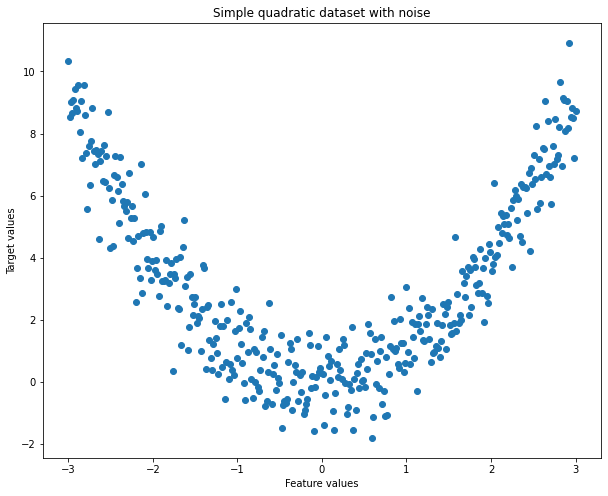

In [13]:
X = np.linspace(-3, 3, 400)
y = X ** 2 + np.random.randn(400)

plt.figure(figsize=(10,8))
plt.scatter(X, y)
plt.title("Simple quadratic dataset with noise")
plt.xlabel("Feature values")
plt.ylabel("Target values")

In [14]:
X = X[:, np.newaxis]

# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape X_test: {X_test.shape}')
print(f'Shape y_test: {y_test.shape}')

Shape X_train: (300, 1)
Shape y_train: (300,)
Shape X_test: (100, 1)
Shape y_test: (100,)


In [15]:
class DecisionTree:
    """
    Decision tree for regression
    """

    def __init__(self):
        self.root_dict = None
        self.tree_dict = None

    def split_dataset(self, X, y, feature_idx, threshold):
        """
        Splits dataset X into two subsets, according to a given feature
        and feature threshold.

        Args:
            X: 2D numpy array with data samples
            y: 1D numpy array with labels
            feature_idx: int, index of feature used for splitting the data
            threshold: float, threshold used for splitting the data

        Returns:
            splits: dict containing the left and right subsets
            and their labels
        """

        left_idx = np.where(X[:, feature_idx] < threshold)
        right_idx = np.where(X[:, feature_idx] >= threshold)

        left_subset = X[left_idx]
        y_left = y[left_idx]

        right_subset = X[right_idx]
        y_right = y[right_idx]

        splits = {
        'left': left_subset,
        'y_left': y_left,
        'right': right_subset,
        'y_right': y_right,
        }

        return splits

    def mean_squared_error(self, y_left, y_right, n_left, n_right):
        """
        Computes MSE of a split.

        Args:
            y_left, y_right: target values of samples in left/right subset
            n_left, n_right: number of samples in left/right subset

        Returns:
            mse_left: float, MSE of left subset
            mse_right: gloat, MSE of right subset
        """

        mse_left, mse_right = 0, 0

        if len(y_left) != 0:
            y_hat_left = (1 / n_left) * np.sum(y_left)
            mse_left = (1 / n_left) * np.sum((y_left - y_hat_left) ** 2)

        if len(y_right) != 0:
            y_hat_right = (1 / n_right) * np.sum(y_right)
            mse_right = (1 / n_right) * np.sum((y_right - y_hat_right) ** 2)

        return mse_left, mse_right

    def get_cost(self, splits):
        """
        Computes cost of a split given the MSE of the left
        and right subset and the sizes of the subsets.

        Args:
            splits: dict, containing params of current split
        """
        y_left = splits['y_left']
        y_right = splits['y_right']

        n_left = len(y_left)
        n_right = len(y_right)
        n_total = n_left + n_right

        mse_left, mse_right = self.mean_squared_error(y_left, y_right, n_left, n_right)
        cost = (n_left / n_total) * mse_left + (n_right / n_total) * mse_right

        return cost

    def find_best_split(self, X, y):
        """
        Finds the best feature and feature index to split dataset X into
        two groups. Checks every value of every attribute as a candidate
        split.

        Args:
            X: 2D numpy array with data samples
            y: 1D numpy array with labels

        Returns:
            best_split_params: dict, containing parameters of the best split
        """

        n_samples, n_features = X.shape
        best_feature_idx, best_threshold, best_cost, best_splits = np.inf, np.inf, np.inf, None

        for feature_idx in range(n_features):
            for i in range(n_samples):
                current_sample = X[i]
                threshold = current_sample[feature_idx]
                splits = self.split_dataset(X, y, feature_idx, threshold)
                cost = self.get_cost(splits)

                if cost < best_cost:
                    best_feature_idx = feature_idx
                    best_threshold = threshold
                    best_cost = cost
                    best_splits = splits

        best_split_params = {
            'feature_idx': best_feature_idx,
            'threshold': best_threshold,
            'cost': best_cost,
            'left': best_splits['left'],
            'y_left': best_splits['y_left'],
            'right': best_splits['right'],
            'y_right': best_splits['y_right'],
        }

        return best_split_params


    def build_tree(self, node_dict, depth, max_depth, min_samples):
        """
        Builds the decision tree in a recursive fashion.

        Args:
            node_dict: dict, representing the current node
            depth: int, depth of current node in the tree
            max_depth: int, maximum allowed tree depth
            min_samples: int, minimum number of samples needed to split a node further

        Returns:
            node_dict: dict, representing the full subtree originating from current node
        """
        left_samples = node_dict['left']
        right_samples = node_dict['right']
        y_left_samples = node_dict['y_left']
        y_right_samples = node_dict['y_right']

        if len(y_left_samples) == 0 or len(y_right_samples) == 0:
            node_dict["left_child"] = node_dict["right_child"] = self.create_terminal_node(np.append(y_left_samples, y_right_samples))
            return None

        if depth >= max_depth:
            node_dict["left_child"] = self.create_terminal_node(y_left_samples)
            node_dict["right_child"] = self.create_terminal_node(y_right_samples)
            return None

        if len(right_samples) < min_samples:
            node_dict["right_child"] = self.create_terminal_node(y_right_samples)
        else:
            node_dict["right_child"] = self.find_best_split(right_samples, y_right_samples)
            self.build_tree(node_dict["right_child"], depth+1, max_depth, min_samples)

        if len(left_samples) < min_samples:
            node_dict["left_child"] = self.create_terminal_node(y_left_samples)
        else:
            node_dict["left_child"] = self.find_best_split(left_samples, y_left_samples)
            self.build_tree(node_dict["left_child"], depth+1, max_depth, min_samples)

        return node_dict

    def create_terminal_node(self, y):
        """
        Creates a terminal node.

        Args:
            y: 1D numpy array with target values
        Returns:
            predicted_value: float, predicted value
        """
        return np.mean(y)

    def train(self, X, y, max_depth, min_samples):
        """
        Fits decision tree on a given dataset.

        Args:
            X: 2D numpy array with data samples
            y: 1D numpy array with labels
            max_depth: int, maximum allowed tree depth
            min_samples: int, minimum number of samples needed to split a node further
        """
        self.n_classes = len(set(y))
        self.root_dict = self.find_best_split(X, y)
        self.tree_dict = self.build_tree(self.root_dict, 1, max_depth, min_samples)

    def predict(self, X, node):
        """
        Predicts the class for a given input example X.

        Args:
            X: 1D numpy array, input example
            node: dict, representing trained decision tree

        Returns:
            prediction: float, predicted value
        """
        feature_idx = node['feature_idx']
        threshold = node['threshold']

        if X[feature_idx] < threshold:
            if isinstance(node['left_child'], (float)):
                return node['left_child']
            else:
                prediction = self.predict(X, node['left_child'])
        elif X[feature_idx] >= threshold:
            if isinstance(node['right_child'], (float)):
                return node['right_child']
            else:
                prediction = self.predict(X, node['right_child'])

        return prediction

In [16]:
tree = DecisionTree()
tree.train(X_train, y_train, max_depth=2, min_samples=2)

In [17]:
def print_tree(node, depth=0):
    if isinstance(node, (float)):
        print(f"{depth * '  '}predicted class: {round(node, 3)}")
    else:
        print(f"{depth * '  '} feature {node['feature_idx']} < {round(node['threshold'], 3)}, "
             f"cost of split: {round(node['cost'], 3)}")
        print_tree(node["left_child"], depth+1)
        print_tree(node["right_child"], depth+1)

In [18]:
print_tree(tree.tree_dict)

 feature 0 < 2.038, cost of split: 6.174
   feature 0 < -1.887, cost of split: 2.436
    predicted class: 6.222
    predicted class: 1.249
   feature 0 < 2.444, cost of split: 1.044
    predicted class: 5.216
    predicted class: 7.785


In [19]:
mse = 0
predictions = []
for i in range(X_test.shape[0]):
    result = tree.predict(X_test[i], tree.tree_dict)
    mse += (y_test[i] - result) ** 2
    predictions.append(result)


mse = (1 / len(y_test)) * mse
print(f"MSE on test set: {round(mse, 3)}")

MSE on test set: 2.288


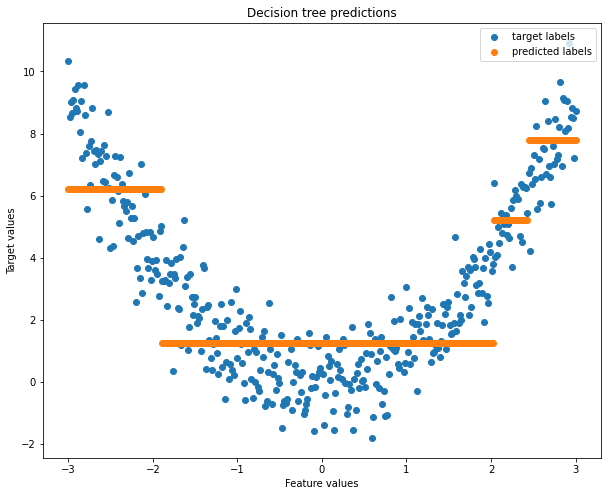

In [20]:
predictions = []
for i in range(X.shape[0]):
    result = tree.predict(X[i], tree.tree_dict)
    predictions.append(result)

plt.figure(figsize=(10, 8))
plt.title("Decision tree predictions")
plt.xlabel("Feature values")
plt.ylabel("Target values")
plt.scatter(X, y, label="target labels")
plt.scatter(X, predictions, label="predicted labels")
plt.legend(loc='upper right')
plt.show()